# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [1]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

c:\Users\jga20\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [3]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

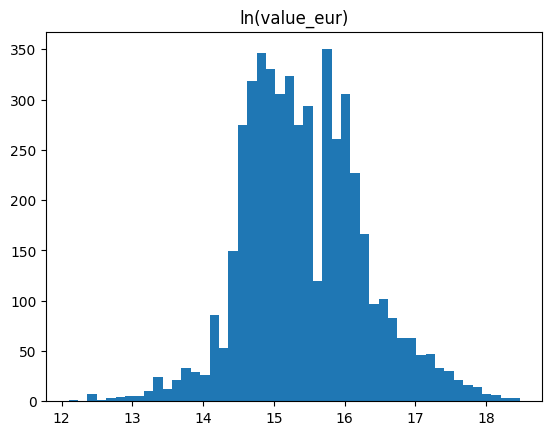

In [4]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [5]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [48]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor()
model.fit(X_train, ylog_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [7]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

In [49]:
# ver si el modelo esta overfitteado
train_score = model.score(X_train, ylog_train)
test_score = model.score(X_test, ylog_test)
print(f"Train R^2: {train_score:.4f}, Test R^2: {test_score:.4f}")

Train R^2: 0.9971, Test R^2: 0.9262


---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [9]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

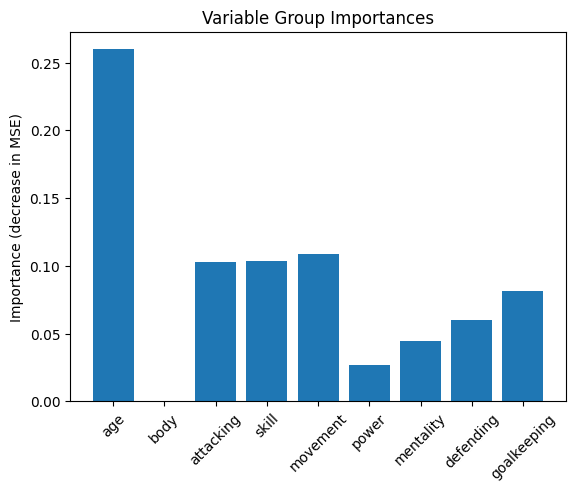

In [52]:
importances = {}
result = permutation_importance(model, X_test, ylog_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error', n_jobs=-1)
for group_name, features in variable_groups.items():
    group_importance = np.sum([result.importances_mean[X_test.columns.get_loc(feat)] for feat in features])
    importances[group_name] = group_importance

plt.bar(importances.keys(), importances.values())
plt.ylabel('Importance (decrease in MSE)')
plt.title('Variable Group Importances')
plt.xticks(rotation=45)
plt.show()


---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

Top variables influencing Leo Messi's value:

                    Feature  SHAP_value
16       movement_reactions    0.960527
12       skill_ball_control    0.787367
4       attacking_finishing    0.229827
6   attacking_short_passing    0.181054
8           skill_dribbling    0.126649
26         mentality_vision    0.093540
22         power_long_shots    0.092120
14    movement_sprint_speed    0.089678
28      mentality_composure    0.083124
13    movement_acceleration    0.074065


C:\Users\jga20\AppData\Local\Temp\ipykernel_23464\437706728.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SHAP_value', y='Feature', data=shap_df.head(10), palette='coolwarm')


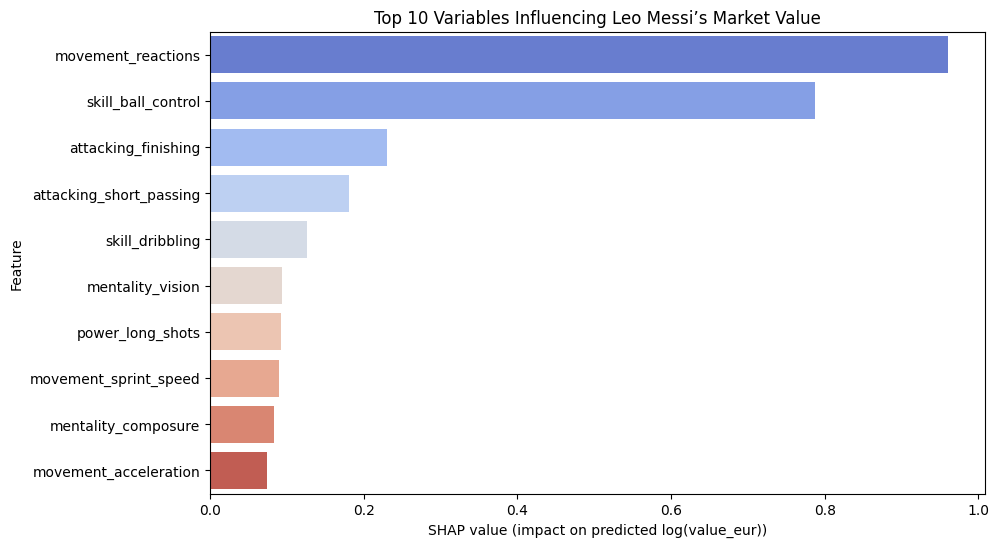

The variable with the highest influence on Leo Messi's value is: movement_reactions


In [53]:
import seaborn as sns
explainer = shap.Explainer(model, X_train)

messi_row = df[df["short_name"].str.contains("Messi", case=False, na=False)]
if messi_row.empty:
    raise ValueError("Leo Messi not found in dataset.")

messi_features = messi_row[X.columns]

messi_shap = explainer(messi_features)

shap.initjs()
shap.force_plot(explainer.expected_value, messi_shap.values[0], messi_features)

shap_df = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_value': messi_shap.values[0]
}).sort_values(by='SHAP_value', key=abs, ascending=False)

print("Top variables influencing Leo Messi's value:\n")
print(shap_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='SHAP_value', y='Feature', data=shap_df.head(10), palette='coolwarm')
plt.title("Top 10 Variables Influencing Leo Messi’s Market Value")
plt.xlabel("SHAP value (impact on predicted log(value_eur))")
plt.show()

top_feature = shap_df.iloc[0]['Feature']
print(f"The variable with the highest influence on Leo Messi's value is: {top_feature}")

>>> He usado SHAP porque te permite ver la importancia de una variable para ciertos registros específicos.

---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

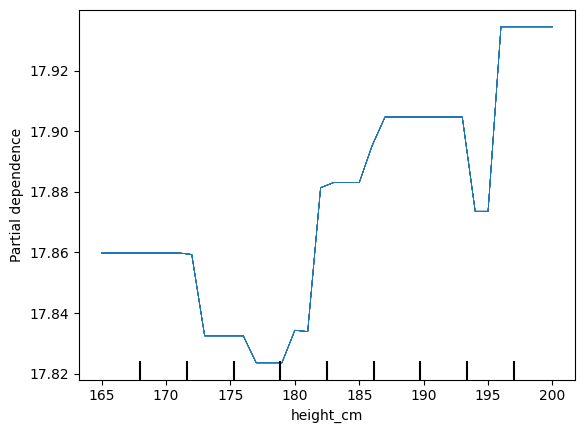

In [54]:
cristiano_df = df[df['short_name'] == 'Cristiano Ronaldo'].reset_index(drop=True)
cristiano_X = cristiano_df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)

different_heights = np.arange(165, 201, 1)
cristiano_X_rep = pd.concat([cristiano_X]*len(different_heights), ignore_index=True)
cristiano_X_rep['height_cm'] = different_heights

PartialDependenceDisplay.from_estimator(
    model,
    cristiano_X_rep,
    features=['height_cm'],
    kind='individual',
)
plt.show()


>>> Se usan PDP porque permite ver la dependencia parcial (en este caso la altura) para ver como afecta al value de un jugador concreto manteniendo el resto de variables constantes. Se ve como, a priori, si aumentas la altura del jugador aumenta el valor ya que al conservar el resto de las características lo único que estás haciendo es mejorar físicamente al jugador.

---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

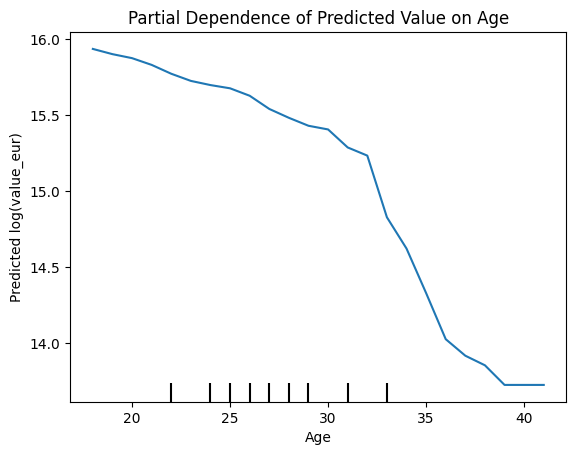

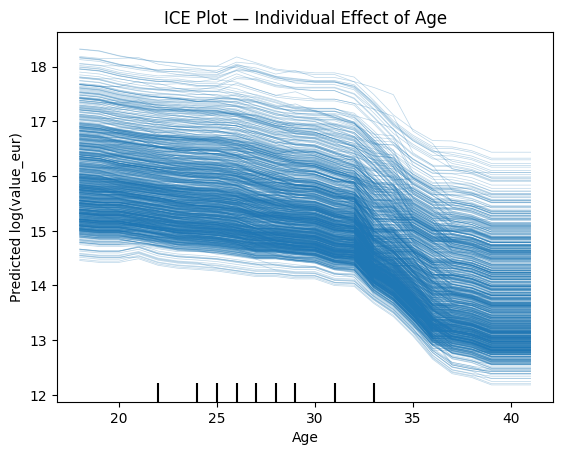

Number of Goalkeepers in test set: 223
Number of Strikers in test set: 310


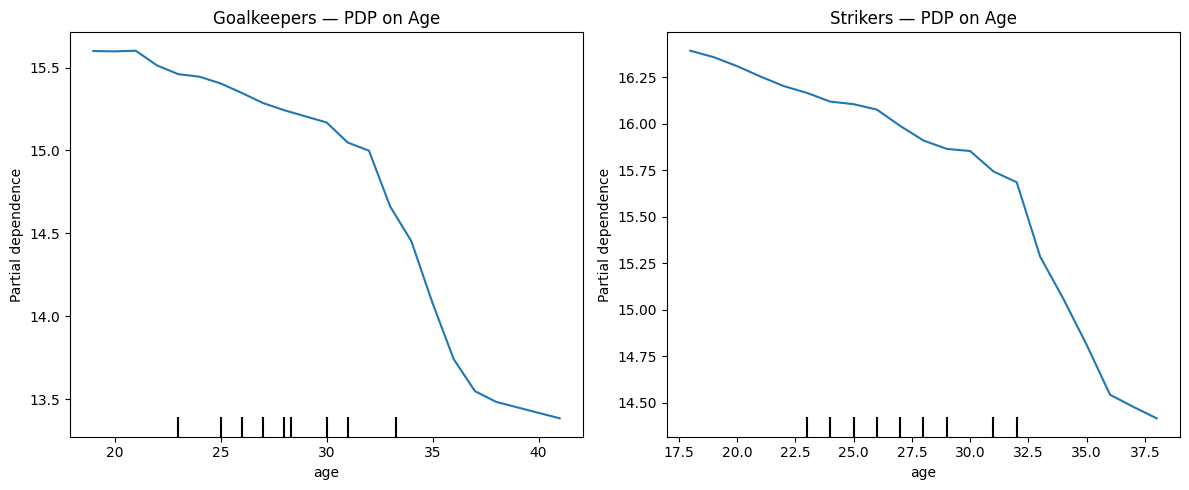

In [45]:

features = ['age']
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average')
plt.title("Partial Dependence of Predicted Value on Age")
plt.xlabel("Age")
plt.ylabel("Predicted log(value_eur)")
plt.show()

PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual')
plt.title("ICE Plot — Individual Effect of Age")
plt.xlabel("Age")
plt.ylabel("Predicted log(value_eur)")
plt.show()


gk_mask = df['attacking_finishing'] < 35   # goalkeepers
st_mask = df['attacking_finishing'] > 70  # strikers

X_gk = X_test[gk_mask.iloc[X_test.index]]
X_st = X_test[st_mask.iloc[X_test.index]]
print(f"Number of Goalkeepers in test set: {X_gk.shape[0]}")
print(f"Number of Strikers in test set: {X_st.shape[0]}")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
PartialDependenceDisplay.from_estimator(model, X_gk, features, kind='average', ax=ax[0])
ax[0].set_title("Goalkeepers — PDP on Age")
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Predicted log(value_eur)")

PartialDependenceDisplay.from_estimator(model, X_st, features, kind='average', ax=ax[1])
ax[1].set_title("Strikers — PDP on Age")
ax[1].set_xlabel("Age")
ax[1].set_ylabel("Predicted log(value_eur)")

plt.tight_layout()
plt.show()

>>> Se ve claramente como la edad afecta más al jugador de campo (en este caso al delantero) que al portero, lo cual tiene sentido.

---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [46]:
from lime.lime_tabular import LimeTabularExplainer

hazard_row = df[df["short_name"].str.contains("Hazard", case=False, na=False)]
if hazard_row.empty:
    raise ValueError("Eden Hazard not found in dataset.")

hazard_features = hazard_row[X.columns].values[0]

# --- 2️⃣ Create the LIME explainer ---
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    mode='regression'
)

# --- 3️⃣ Explain the prediction for Hazard ---
exp = explainer.explain_instance(
    data_row=hazard_features,
    predict_fn=model.predict,
    num_features=10  # top 10 influential features
)

from IPython.display import HTML, display

# Generate the HTML explanation
html_explanation = exp.as_html(show_table=True)

# Display it in the notebook
display(HTML(html_explanation))

# --- 5️⃣ Text summary (for report) ---
print("Top features influencing Eden Hazard’s predicted market value:")
for feature, weight in exp.as_list():
    sign = "↑" if weight > 0 else "↓"
    print(f"{feature:40s} {sign} {weight:.3f}")

Top features influencing Eden Hazard’s predicted market value:
movement_reactions > 75.00               ↑ 0.371
skill_ball_control > 76.00               ↑ 0.350
attacking_finishing > 70.00              ↑ 0.274
attacking_short_passing > 75.00          ↑ 0.205
skill_dribbling > 76.00                  ↑ 0.168
mentality_vision > 72.00                 ↑ 0.158
movement_sprint_speed > 77.00            ↑ 0.133
mentality_positioning > 73.00            ↑ 0.114
defending_standing_tackle <= 32.00       ↓ -0.081
52.00 < attacking_heading_accuracy <= 63.00 ↓ -0.079


>>> Vemos como Hazard destaca en su movimiento, su agilidad con el balón y su ataque, lo cual concuerda con lo visto en el Chelsea porque con el Madrid poca cosa :)